In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
df = pd.read_csv('insurance - insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Do smokers have higher insurance charges than non-smokers?

- Null Hypothesis: Smokers do not have different insurance charges than non-smokers.
- Alternative Hypothesis: Smokers have higher insurance charges than non-smokers.

### Independent T-test

In [3]:
sample = df.sample(n=50,random_state=42)
smoker = sample.loc[ sample['smoker']=='yes',"charges"]
non_smoker = sample.loc[ sample['smoker']=='no',"charges"]

In [4]:
# check for outliers
zscores_f = stats.zscore(smoker)
outliers_f = abs(zscores_f)>3
np.sum(outliers_f)

0

In [5]:
# check for outliers
zscores_f = stats.zscore(non_smoker)
outliers_f = abs(zscores_f)>3
np.sum(outliers_f)

0

In [6]:
# normal test smokers
result_m = stats.normaltest(smoker)
result_m

/Users/Alex/opt/anaconda3/envs/dojo-env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


NormaltestResult(statistic=2.209358578032982, pvalue=0.331317122245031)

In [7]:
# normal test non-smokers
result_m = stats.normaltest(non_smoker)
result_m

NormaltestResult(statistic=2.6262187199374125, pvalue=0.26898239167805005)

In [8]:
# check variance
result = stats.levene(smoker, non_smoker)
result

LeveneResult(statistic=18.397400827816167, pvalue=8.621214599569032e-05)

In [9]:
# Independent t-test with equal_var set to False
result = stats.ttest_ind(smoker, non_smoker, equal_var = False)
result

Ttest_indResult(statistic=8.559207952113589, pvalue=3.4904271993679657e-06)

In [10]:
## is our result significant
print(f"p-value={result.pvalue:.10f}")
print(f"Significant: {result.pvalue <.05}")

p-value=0.0000034904
Significant: True


- I reject the null hypothesis because p < 0.05
- This means that there is a significant difference between insurance charges of smokers and non-smokers

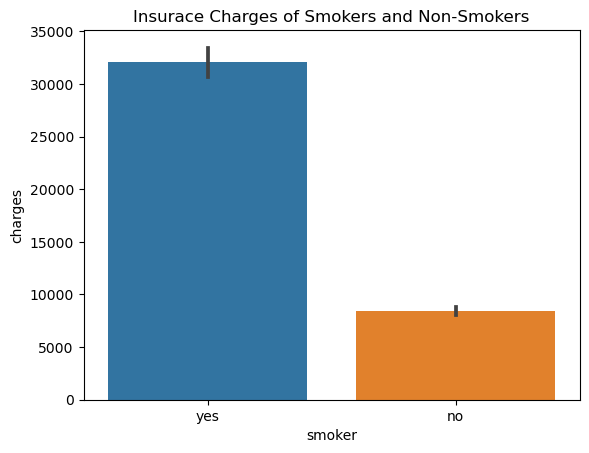

In [11]:
sns.barplot(data = df, x = 'smoker', y = 'charges').set(title = 'Insurace Charges of Smokers and Non-Smokers');

## Are men more likely to smoke than women?

- Null Hypothesis: There is no difference between the likelihood of men and women smoking.
- Alternative Hypothesis: Men are more likely to smoke than women.

### Chi-Square Test

In [12]:
# calculate the contingency table with pd.cross-tab
table = pd.crosstab(df['sex'], df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [13]:
# Run the Test and Save the Output
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result

In [14]:
# Print p-value
print(p)
p<.05

0.006548143503580696


True

- I reject the null hypothesis because p < 0.05
- This means that men are more likely to smoke than women

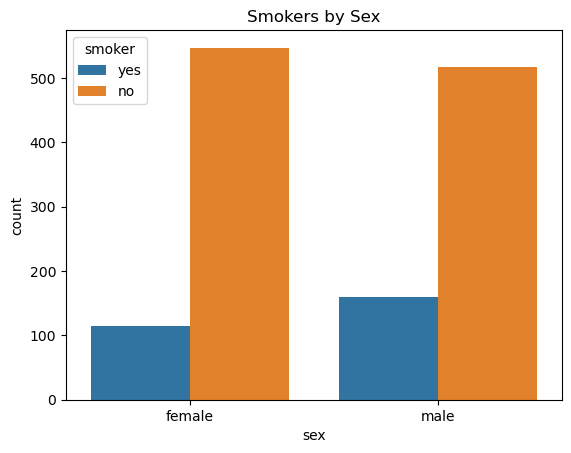

In [15]:
ax = sns.countplot(data=df, x='sex',hue='smoker',)
ax.set_title("Smokers by Sex");

## Do different regions have different charges, on average?

- Null Hypothesis: Different regions do not have different insurance charges. 
- Alternative Hypothesis: Different regions have different insurance charges, on average.

### ANOVA Test

In [16]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [17]:
regions = {}
## Loop through all unique categories
for i in df['region'].unique():
    ## Get series for group and rename
    data = df.loc[df['region']==i,'charges'].copy()
    
    # save into the dictionary
    regions[i] = data
regions.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

In [18]:
# check for outliers
zscores_f = stats.zscore(data)
outliers_f = abs(zscores_f)>3
np.sum(outliers_f)

4

In [19]:
# remove outliers
data = data[(np.abs(stats.zscore(data)) < 3)]

In [20]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in regions.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
southwest,325.0,6.125298e-23,102.294059
southeast,364.0,4.953297e-15,65.877446
northwest,325.0,5.184209e-24,107.232850
northeast,324.0,1.455431e-19,86.747629


In [21]:
### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
southwest,325.0,6.125298e-23,102.294059,True
southeast,364.0,4.953297e-15,65.877446,True
northwest,325.0,5.184209e-24,107.232850,True
northeast,324.0,1.455431e-19,86.747629,True


In [22]:
# checking variance
stats.levene(*regions.values())

LeveneResult(statistic=5.559966758410606, pvalue=0.0008610590250786703)

In [23]:
# perform correct hypothesis test
result = stats.kruskal( *regions.values())
result

KruskalResult(statistic=4.734181215658743, pvalue=0.19232908072121002)

In [24]:
## save the values
values = df['charges']
labels = df['region']

In [25]:
## perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
northeast,northwest,-988.8091,0.7245,-3428.9343,1451.3161,False
northeast,southeast,1329.0269,0.4745,-1044.9417,3702.9955,False
northeast,southwest,-1059.4471,0.6792,-3499.5723,1380.6781,False
northwest,southeast,2317.8361,0.0583,-54.1994,4689.8716,False
northwest,southwest,-70.638,0.9999,-2508.8826,2367.6066,False
southeast,southwest,-2388.4741,0.0477,-4760.5096,-16.4386,True


- The only significant difference in charges is between the southeast and southwest. For this, we would reject the null hypothesis. For all other comparisons I fail to reject the null hypothesis. 


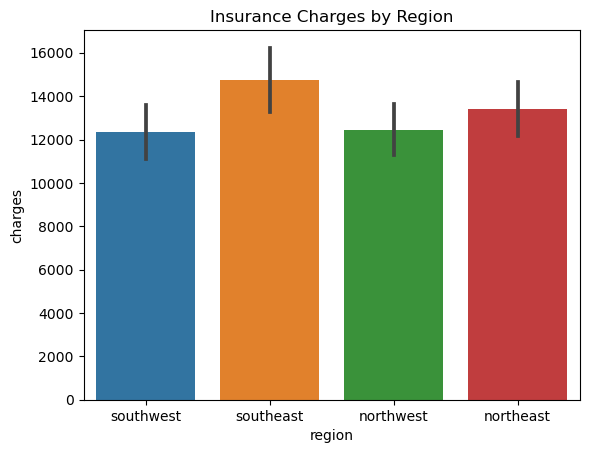

In [26]:
sns.barplot(data=df, x='region',y='charges').set(title = 'Insurance Charges by Region');